## Load libraries

In [65]:
import numpy as np
import pandas as pd
#import random
import time
import matplotlib.pyplot as plt

plt.style.reload_library()

from sktime.classification.interval_based import RandomIntervalSpectralEnsemble
from sktime.classification.dictionary_based import ContractableBOSS, BOSSEnsemble
from sktime.datatypes._panel._convert import from_2d_array_to_nested

from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import RidgeClassifierCV

from wildboar.explain.counterfactual import counterfactuals
from wildboar.explain._importance import IntervalImportance
from wildboar.datasets import list_datasets, load_dataset
from wildboar.ensemble import ShapeletForestClassifier

import pywt
from pywt import wavedec, waverec

from tqdm.notebook import tqdm

import pickle

# UCR time series datasets: https://www.cs.ucr.edu/%7Eeamonn/time_series_data_2018/

In [ ]:
from sktime.transformations.panel.rocket import Rocket

## Load dataset

In [8]:
UCR_datasets = list_datasets(repository='wildboar/ucr')

dataset_info = pd.DataFrame(columns=['size', 'classes', 'length'], index=UCR_datasets, dtype=float)

for dataset in tqdm(UCR_datasets):
    x_all, y_all = load_dataset(dataset, repository='wildboar/ucr')

    # remove rows wirandomth missing values
    x = x_all[~np.isnan(x_all).any(axis=1)]
    y = y_all[~np.isnan(x_all).any(axis=1)]

    classes = np.unique(y)  # all class labels
    total_examples, ts_length = x.shape

    dataset_info.loc[dataset] = [total_examples, len(classes), ts_length]

## Drop rows that have a value of zero in a column
dataset_info = dataset_info.loc[~(dataset_info == 0).any(axis=1)]
dataset_info = dataset_info.loc[~(dataset_info == 1).any(axis=1)]

dataset_info.to_pickle('data/datasets_information.pkl')

  0%|          | 0/128 [00:00<?, ?it/s]

In [9]:
#pickle.dump(UCR_datasets, 'data/UCR_datasets.pkl', protocol = 2)

In [10]:
dataset_info = pd.read_pickle('data/datasets_information.pkl')

In [11]:
dataset_info

,size,classes,length
ACSF1,200.0,10.0,1460.0
Adiac,781.0,37.0,176.0
ArrowHead,211.0,3.0,251.0
BME,180.0,3.0,128.0
Beef,60.0,5.0,470.0
...,...,...,...
Wine,111.0,2.0,234.0
WordSynonyms,905.0,25.0,270.0
Worms,258.0,5.0,900.0
WormsTwoClass,258.0,2.0,900.0


In [12]:
dataset_info.describe()

,size,classes,length
count,117.000000,117.000000,117.000000
mean,1581.572650,8.264957,537.102564
std,2996.395773,12.256872,583.137433
min,40.000000,2.000000,15.000000
25%,258.000000,2.000000,136.000000
50%,724.000000,3.000000,301.000000
75%,1272.000000,7.000000,720.000000
max,24000.000000,60.000000,2844.000000


In [13]:
dataset_info.quantile(.70)

size       1035.2
classes       6.2
length      571.4
Name: 0.7, dtype: float64

In [14]:
# select subset of all datasets
lb_size = 1
up_size = 200
lb_length = 10
up_length = 1000
lb_class = 2
up_class = 8

dataset_info = pd.read_pickle('data/datasets_information.pkl')

selected = dataset_info.loc[
    (dataset_info['size'] >= lb_size) & (dataset_info['size'] <= up_size) & (dataset_info['classes'] >= lb_class) & (
            dataset_info['classes'] <= up_class) & (dataset_info['length'] >= lb_length) & (
            dataset_info['length'] <= up_length)]



# condition = (dataset_info['classes'] <= classes_ub) & (dataset_info['classes'] >= classes_lb) 
# selected = dataset_info.loc[condition]


In [15]:
selected

,size,classes,length
BME,180.0,3.0,128.0
Beef,60.0,5.0,470.0
BeetleFly,40.0,2.0,512.0
BirdChicken,40.0,2.0,512.0
Car,120.0,4.0,577.0
Coffee,56.0,2.0,286.0
DodgerLoopDay,144.0,7.0,288.0
DodgerLoopGame,144.0,2.0,288.0
DodgerLoopWeekend,144.0,2.0,288.0
ECG200,200.0,2.0,96.0


In [16]:
selected_datasets = selected.index.to_list()

#classifiers = ["kNN","RSF","Rocket","RISE","BOSS","DFT","DWT"]
classifiers = ["kNN", "RSF", "Rocket", "DFT", "DWT"]
classifiers = ["DFT", "DWT"]

index_dataset = 3
splits = 2

dataset = selected_datasets[index_dataset]

print(dataset)
print(type(dataset))
iterables = [[dataset], np.arange(splits)]
m_index = pd.MultiIndex.from_product(iterables, names=["dataset", "split"])

accuracies = pd.DataFrame(columns=classifiers, index=m_index, dtype=float)
complexity = pd.DataFrame(columns=classifiers, index=m_index, dtype=float)

x_all, y_all = load_dataset(dataset, repository='wildboar/ucr')

# remove rows wirandomth missing values
x = x_all[~np.isnan(x_all).any(axis=1)]
y = y_all[~np.isnan(x_all).any(axis=1)]

classes = np.unique(y)  # all class labels
total_examples, ts_length = x.shape

x_ind = np.arange(total_examples)

max_len_coef_DFT = int(ts_length / 2 + 1)  # maximum number of DFT coefficients
max_len_coef_DWT = ts_length  # maximum number of DWT coefficients

for i in tqdm(range(splits), desc=dataset, leave=False):

    # implement same split across all

    x_train_ind, x_test_ind, y_train, y_test = train_test_split(x_ind, y, test_size=.30, random_state=i, shuffle=True,
                                                                stratify=None)
    x_train2_ind, x_val_ind, y_train2, y_val = train_test_split(x_train_ind, y_train, test_size=.20, random_state=i,
                                                                shuffle=True, stratify=None)

    x_train = x[x_train_ind, :]
    x_test = x[x_test_ind, :]
    # x_train.to_csv('out.csv', index=False)
    np.random.seed(i)

    ## kNN
    if 'kNN' in classifiers:
        knn_time_start = time.time()

        clf_kNN = KNeighborsClassifier(metric="euclidean")
        clf_kNN.fit(x_train, y_train)
        acc = clf_kNN.score(x_test, y_test)

        knn_time_end = time.time()

        accuracies.loc[(dataset, i), "kNN"] = acc
        complexity.loc[(dataset, i), "kNN"] = knn_time_end - knn_time_start
    # ----------

    ## RSF
    if 'RSF' in classifiers:
        rsf_time_start = time.time()

        clf_RSF = ShapeletForestClassifier(n_estimators=50, metric='scaled_euclidean')
        clf_RSF.n_features_in_ = x_train.shape[-1]
        clf_RSF.fit(x_train, y_train)
        acc = clf_RSF.score(x_test, y_test)

        rsf_time_end = time.time()
        accuracies.loc[(dataset, i), "RSF"] = acc
        complexity.loc[(dataset, i), "RSF"] = rsf_time_end - rsf_time_start

    # ----------

    ## ROCKET
    if 'Rocket' in classifiers:
        rocket_time_start = time.time()

        rocket = Rocket(num_kernels=20000, normalise=False, n_jobs=1,
                        random_state=None)  # by default, ROCKET uses 10,000 kernels
        rocket.fit(np.expand_dims(x_train, axis=1))

        # transform training set and train classifier
        x_training_transform = rocket.transform(np.expand_dims(x_train, axis=1))

        classifierRocket = make_pipeline(StandardScaler(), RidgeClassifierCV(alphas=np.logspace(-3, 3, 10)))

        classifierRocket.fit(x_training_transform, y_train)

        # transform test set and predict
        x_test_transform = rocket.transform(np.expand_dims(x_test, axis=1))
        # predictions = classifierRocket.predict(x_test_transform)
        acc = classifierRocket.score(x_test_transform, y_test)

        rocket_time_end = time.time()

        accuracies.loc[(dataset, i), "Rocket"] = acc
        complexity.loc[(dataset, i), "Rocket"] = rocket_time_end - rocket_time_start
    # -------------

    ## RISE
    if 'RISE' in classifiers:
        rise_time_start = time.time()
        classifierRISE = RandomIntervalSpectralEnsemble(random_state=i)

        x_train_nested = from_2d_array_to_nested(x_train)
        x_test_nested = from_2d_array_to_nested(x_test)

        classifierRISE.fit(x_train_nested, y_train)
        # predictions = classifierRISE.predict(x_test_nested)
        acc = classifierRISE.score(x_test_nested, y_test)
        rise_time_end = time.time()

        accuracies.loc[(dataset, i), "RISE"] = acc
        complexity.loc[(dataset, i), "RISE"] = rise_time_end - rise_time_start
    # --------------

    ## BOSS
    if 'BOSS' in classifiers:
        boss_time_start = time.time()
        classifierBOSS = BOSSEnsemble(random_state=i)

        x_train_nested = from_2d_array_to_nested(x_train)
        x_test_nested = from_2d_array_to_nested(x_test)

        classifierBOSS.fit(x_train_nested, y_train)
        # predictions = classifierBOSS.predict(x_test_nested)
        acc = classifierBOSS.score(x_test_nested, y_test)
        boss_time_end = time.time()

        accuracies.loc[(dataset, i), "BOSS"] = acc
        complexity.loc[(dataset, i), "BOSS"] = boss_time_end - boss_time_start
    # --------------

    ## DFT
    ## Changing the number of lower frequencies features using a sliding bar
    if 'DFT' in classifiers:

        dft_time_start = time.time()

        # Freq domain
        X_F = np.fft.rfft(x)

        # combine amp and phase into one array
        X_F_train = np.empty((x_train2_ind.shape[0], 2 * max_len_coef_DFT))
        X_F_val = np.empty((x_val_ind.shape[0], 2 * max_len_coef_DFT))
        X_F_test = np.empty((x_test.shape[0], 2 * max_len_coef_DFT))

        X_F_train[:, 0::2] = normalize(np.absolute(X_F[x_train2_ind, :]), axis=1)  # amplitude
        X_F_train[:, 1::2] = normalize(np.angle(X_F[x_train2_ind, :]), axis=1)  # phase
        X_F_val[:, 0::2] = normalize(np.absolute(X_F[x_val_ind, :]), axis=1)  # amplitude
        X_F_val[:, 1::2] = normalize(np.angle(X_F[x_val_ind, :]), axis=1)  # phase
        X_F_test[:, 0::2] = normalize(np.absolute(X_F[x_test_ind, :]), axis=1)  # amplitude
        X_F_test[:, 1::2] = normalize(np.angle(X_F[x_test_ind, :]), axis=1)  # phase

        fracs = [.1, .25, .5, .75, 1]
        acc_val = np.empty(len(fracs))
        acc_test = np.empty(len(fracs))

        for idx, L_DFT_frac in enumerate(fracs):
            L_DFT = int(L_DFT_frac * max_len_coef_DFT)
            clf = ExtraTreesClassifier(random_state=1)
            clf.fit(X_F_train[:, :2 * L_DFT], y_train2)
            acc_val[idx] = clf.score(X_F_val[:, :2 * L_DFT], y_val)
            acc_test[idx] = clf.score(X_F_test[:, :2 * L_DFT], y_test)

        dft_time_end = time.time()

        accuracies.loc[(dataset, i), "DFT"] = acc_test[np.argmax(acc_val)]
        complexity.loc[(dataset, i), "DFT"] = dft_time_end - dft_time_start

    # --------------
    ## Changing the number of lower frequencies features using a sliding bar

    if 'DWT' in classifiers:

        dwt_time_start = time.time()

        # Time-Freq domain
        level = 3  # no of DWT decomposition levels
        waveletname = 'db2'

        X_TF = wavedec(x, waveletname, level=level)  ## If using DWT
        X_TF_stacked = np.hstack(X_TF)

        X_TF_train = X_TF_stacked[x_train2_ind, :]
        X_TF_val = X_TF_stacked[x_val_ind, :]
        X_TF_test = X_TF_stacked[x_test_ind, :]

        fracs = [.1, .25, .5, .75, .1]
        acc_val = np.empty(len(fracs))
        acc_test = np.empty(len(fracs))
        for idx, L_DWT_frac in enumerate(fracs):
            L_DWT = int(L_DWT_frac * max_len_coef_DWT)
            clf = ExtraTreesClassifier(random_state=1)

            clf.fit(X_TF_train[:, :L_DWT], y_train2)
            acc_val[idx] = clf.score(X_TF_val[:, :L_DWT], y_val)
            acc_test[idx] = clf.score(X_TF_test[:, :L_DWT], y_test)

        dwt_time_end = time.time()

        accuracies.loc[(dataset, i), "DWT"] = acc_test[np.argmax(acc_val)]
        complexity.loc[(dataset, i), "DWT"] = dwt_time_end - dwt_time_start
        # --------------

        # save results
        #accuracies.to_pickle('data/accuracies_new.pkl')
        #complexity.to_pickle('data/complexity_new.pkl')




BirdChicken
<class 'str'>


BirdChicken:   0%|          | 0/2 [00:00<?, ?it/s]

In [17]:
print(accuracies)

                        DFT       DWT
dataset     split                    
BirdChicken 0      0.916667  0.750000
            1      0.916667  0.916667


In [35]:
from wildboar.explain import IntervalImportance

ImportError: cannot import name 'IntervalImportance' from 'wildboar.explain' (/Users/arvinrastegar/opt/anaconda3/envs/Extremum/lib/python3.7/site-packages/wildboar/explain/__init__.py)

In [62]:
# int_kNN = IntervalImportance(clf_kNN, x_train, y_train)
# int_RSF = IntervalImportance(clf_RSF, x_train, y_train)
i_knn = IntervalImportance(
    # n_interval=72,
    # scoring="accuracy",
    # domain="frequency",
    # verbose=True,
    # random_state=123,
)
i_rsf = IntervalImportance(
    # n_interval=72,
    # scoring="accuracy",
    # domain="frequency",
    # verbose=True,
    # random_state=123,
)
i_knn.fit(clf_kNN, x_train, y_train)
i_rsf.fit(clf_RSF, x_train, y_train)
ax = i_knn.plot(
    x_test,
    y_test,
    top_k=0.2,
    n_samples=0.1,
    jitter=True,
    frequency=24 / 720,
    show_frequency=True,
)
ax = i_rsf.plot(
    x_train, y_train,
    top_k=0.2,
    n_samples=0.1,
    jitter=True,
    frequency=24 / 720,
    show_frequency=True,
)
plt.show()


AttributeError: module 'wildboar' has no attribute 'iseos'

In [61]:
y_test

array([-1.,  1., -1., -1., -1.,  1.,  1., -1., -1., -1.,  1., -1., -1.,
        1., -1., -1., -1., -1.,  1., -1., -1.,  1.,  1.,  1., -1., -1.,
       -1., -1., -1.,  1.,  1., -1., -1., -1.,  1.,  1.,  1., -1.,  1.,
       -1., -1., -1.,  1., -1.,  1., -1., -1., -1., -1., -1., -1.,  1.,
       -1., -1.])

In [19]:
## Counterfactual Explanations RSF and KNN

In [20]:
selected_datasets = selected.index.to_list()

index_dataset = 0

dataset = selected_datasets[index_dataset]

x_all, y_all = load_dataset(dataset, repository='wildboar/ucr')

# remove rows wirandomth missing values
x = x_all[~np.isnan(x_all).any(axis=1)]
y = y_all[~np.isnan(x_all).any(axis=1)]

classes = np.unique(y)  # all class labels
total_examples, ts_length = x.shape

x_ind = np.arange(total_examples)

x_train_ind, x_test_ind, y_train, y_test = train_test_split(x_ind, y, test_size=.30, random_state=0, shuffle=True,
                                                            stratify=None)

x_train = x[x_train_ind, :]
x_test = x[x_test_ind, :]

y_train[y_train != 1.0] = -1.0
y_test[y_test != 1.0] = -1.0

clf_kNN = KNeighborsClassifier(metric="euclidean")
clf_kNN.fit(x_train, y_train)

#clf_RSF = ShapeletForestClassifier(n_estimators=50, metric='scaled_euclidean')
clf_RSF = ShapeletForestClassifier(
    n_estimators=20,
    metric='euclidean',
    max_depth=5,
    max_shapelet_size=.4,  # INTERACTION: Make this as input from user
    random_state=1,
)
clf_RSF.n_features_in_ = x_train.shape[-1]
clf_RSF.fit(x_train, y_train)

x_counterfactual_RSF, x_valid_RSF, x_score_RSF = counterfactuals(
    clf_RSF,
    x_test,
    -y_test,  # invert the classes, i.e., transform 1 -> -1 and -1 -> 1
    scoring="euclidean",
    valid_scoring=False,
    random_state=2,
    epsilon=1,
)
x_counterfactual_kNN, x_valid_kNN, x_score_kNN = counterfactuals(
    clf_kNN,
    x_test,
    -y_test,  # invert the classes, i.e., transform 1 -> -1 and -1 -> 1
    scoring="euclidean",
    valid_scoring=False,
)


In [ ]:
sel_instance_idx = 5
x_counter_RSF = x_counterfactual_RSF[sel_instance_idx, :]
x_counter_kNN = x_counterfactual_kNN[sel_instance_idx, :]

fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot()

ax.plot(x_counterfactual_RSF[sel_instance_idx, :], "-", c="tab:blue", label="CE: RSF")
ax.plot(x_counterfactual_kNN[sel_instance_idx, :], "-.", c="tab:red", label="CE: kNN")
ax.plot(x_test[sel_instance_idx, :], "--", c="k", label="class 1 time series")
ax.set_ylabel('horizontal position of right hand')
ax.set_xlabel('time index')
ax.grid()
ax.legend()
#plt.savefig("GP_CE_RSF_kNN.pdf", dpi=100, bbox_inches="tight", format="pdf")

In [ ]:
print(x_counterfactual_RSF[sel_instance_idx, :])

In [106]:
y

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2.

In [109]:
selected_datasets = selected.index.to_list()

index_dataset = 0

dataset = selected_datasets[index_dataset]

x_all, y_all = load_dataset(dataset, repository='wildboar/ucr')

# remove rows wirandomth missing values
x = x_all[~np.isnan(x_all).any(axis=1)]
y = y_all[~np.isnan(x_all).any(axis=1)]

y = y - 1

classes = np.unique(y)  # all class labels
total_examples, ts_length = x.shape

x_ind = np.arange(total_examples)

x_train_ind, x_test_ind, y_train, y_test = train_test_split(x_ind, y, test_size=.30, random_state=0, shuffle=True,
                                                            stratify=None)

max_len_coef_DFT = int(ts_length / 2 + 1)  # maximum number of DFT coefficients
max_len_coef_DWT = ts_length  # maximum number of DWT coefficients

L_DFT_frac = .35  # INTERACTION: let the user select this fraction of features to have

# Freq domain
X_F = np.fft.rfft(x)

# combine amp and phase into one array
X_F_train = np.empty((x_train_ind.shape[0], 2 * max_len_coef_DFT))
X_F_test = np.empty((x_test.shape[0], 2 * max_len_coef_DFT))

X_F_train[:, 0::2] = normalize(np.absolute(X_F[x_train_ind, :]), axis=1)  # amplitude
X_F_train[:, 1::2] = normalize(np.angle(X_F[x_train_ind, :]), axis=1)  # phase
X_F_test[:, 0::2] = normalize(np.absolute(X_F[x_test_ind, :]), axis=1)  # amplitude
X_F_test[:, 1::2] = normalize(np.angle(X_F[x_test_ind, :]), axis=1)  # phase

L_DFT = int(L_DFT_frac * max_len_coef_DFT)

clf = ExtraTreesClassifier(random_state=1)
clf.fit(X_F_train[:, :2 * L_DFT], y_train)

print(clf.score(X_F_test[:, :2 * L_DFT], y_test))


0.981651376146789


# Counterfactual Explanation using Growing Spheres

In [101]:
#import sys
#!git clone https://github.com/thibaultlaugel/growingspheres.git
#sys.path.append('growingspheres')

#from growingspheres import counterfactuals as counterfactuals_gs
#from growingspheres import growingspheres
#from growingspheres.utils import gs_utils

In [112]:

#obs = data_point.reshape(1,-1)

#CF = counterfactuals_gs.CounterfactualExplanation(obs, clf.predict, target_class = None, method='GS', random_state = 123)
#CF.fit(n_in_layer=2000, first_radius=5, dicrease_radius=50, sparse=False, verbose=True)
#CF.enemy

#cex_amp_all = np.concatenate((test_norm_amp[data_idx]*CF.enemy, X_F_test_amp[data_idx,L:]), axis = 0)
#cex_time_FD = np.fft.irfft(cex_amp_all*np.exp(1j*test_norm_ang[data_idx]*X_F_test_ang[data_idx,:]))


# Visualizing the aplitude and phases of the DFT coefficients

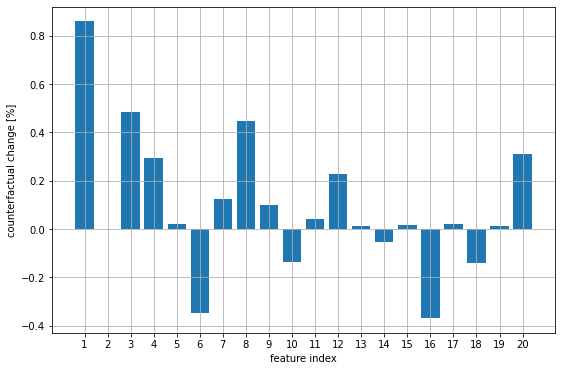

In [118]:
L_DFT = 10  # TODO: sliding bar for user input (maximum : max_len_coef_DFT)
x_labels = range(1, 2 * L_DFT + 1)
intance = 4
data_point = X_F_test[intance, :2 * L_DFT]
data_point_class = y_test[intance]

fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot()
#ax.plot(x_labels,changes.T)
#ax.bar(x_labels,ce_change, width=0.5,facecolor="tab:orange" )
#ax.bar(x_labels, 100*np.nanmean(changes_dec - 1,axis=0).T, width=0.5,facecolor="tab:orange")
ax.bar(x_labels, data_point)
ax.set_ylabel('counterfactual change [%]')
ax.set_xlabel('feature index')
plt.xticks(ticks=x_labels)
ax.grid(1)
#ax.set_ylim(-50,100)

In [52]:
selected_datasets = selected.index.to_list()

classifiers = ["kNN", "RSF", "Rocket", "RISE", "BOSS", "DFT", "DWT"]

splits = 5

iterables = [selected_datasets, np.arange(splits)]
m_index = pd.MultiIndex.from_product(iterables, names=["dataset", "split"])

accuracies = pd.DataFrame(columns=classifiers, index=m_index, dtype=float)
complexity = pd.DataFrame(columns=classifiers, index=m_index, dtype=float)

for dataset in tqdm(selected_datasets, desc='overall progress'):
    x_all, y_all = load_dataset(dataset, repository='wildboar/ucr')

    # remove rows wirandomth missing values
    x = x_all[~np.isnan(x_all).any(axis=1)]
    y = y_all[~np.isnan(x_all).any(axis=1)]

    classes = np.unique(y)  # all class labels
    total_examples, ts_length = x.shape

    x_ind = np.arange(total_examples)

    max_len_coef_DFT = int(ts_length / 2 + 1)  # maximum number of DFT coefficients
    max_len_coef_DWT = ts_length  # maximum number of DWT coefficients

    for i in tqdm(range(splits), desc=dataset, leave=False):

        # implement same split across all

        x_train_ind, x_test_ind, y_train, y_test = train_test_split(x_ind, y, test_size=.30, random_state=i,
                                                                    shuffle=True, stratify=None)
        x_train2_ind, x_val_ind, y_train2, y_val = train_test_split(x_train_ind, y_train, test_size=.20, random_state=i,
                                                                    shuffle=True, stratify=None)

        x_train = x[x_train_ind, :]
        x_test = x[x_test_ind, :]

        np.random.seed(i)

        ## kNN
        if 'kNN' in classifiers:
            knn_time_start = time.time()

            f = KNeighborsClassifier(metric="euclidean")
            f.fit(x_train, y_train)
            acc = f.score(x_test, y_test)

            knn_time_end = time.time()

            accuracies.loc[(dataset, i), "kNN"] = acc
            complexity.loc[(dataset, i), "kNN"] = knn_time_end - knn_time_start
        # ----------

        ## RSF
        if 'RSF' in classifiers:
            rsf_time_start = time.time()

            f = ShapeletForestClassifier(n_estimators=50, metric='scaled_euclidean')
            f.n_features_in_ = x_train.shape[-1]
            f.fit(x_train, y_train)
            acc = f.score(x_test, y_test)

            rsf_time_end = time.time()
            accuracies.loc[(dataset, i), "RSF"] = acc
            complexity.loc[(dataset, i), "RSF"] = rsf_time_end - rsf_time_start

        # ----------

        ## ROCKET
        if 'Rocket' in classifiers:
            rocket_time_start = time.time()

            rocket = Rocket(num_kernels=20000, normalise=False, n_jobs=1,
                            random_state=None)  # by default, ROCKET uses 10,000 kernels
            rocket.fit(np.expand_dims(x_train, axis=1))

            # transform training set and train classifier
            x_training_transform = rocket.transform(np.expand_dims(x_train, axis=1))

            classifierRocket = make_pipeline(StandardScaler(), RidgeClassifierCV(alphas=np.logspace(-3, 3, 10)))

            classifierRocket.fit(x_training_transform, y_train)

            # transform test set and predict
            x_test_transform = rocket.transform(np.expand_dims(x_test, axis=1))
            # predictions = classifierRocket.predict(x_test_transform)
            acc = classifierRocket.score(x_test_transform, y_test)

            rocket_time_end = time.time()

            accuracies.loc[(dataset, i), "Rocket"] = acc
            complexity.loc[(dataset, i), "Rocket"] = rocket_time_end - rocket_time_start
        # -------------

        ## RISE
        if 'RISE' in classifiers:
            rise_time_start = time.time()
            classifierRISE = RandomIntervalSpectralEnsemble(random_state=i)

            x_train_nested = from_2d_array_to_nested(x_train)
            x_test_nested = from_2d_array_to_nested(x_test)

            classifierRISE.fit(x_train_nested, y_train)
            # predictions = classifierRISE.predict(x_test_nested)
            acc = classifierRISE.score(x_test_nested, y_test)
            rise_time_end = time.time()

            accuracies.loc[(dataset, i), "RISE"] = acc
            complexity.loc[(dataset, i), "RISE"] = rise_time_end - rise_time_start
        # --------------

        ## BOSS
        if 'BOSS' in classifiers:
            boss_time_start = time.time()
            classifierBOSS = BOSSEnsemble(random_state=i)

            x_train_nested = from_2d_array_to_nested(x_train)
            x_test_nested = from_2d_array_to_nested(x_test)

            classifierBOSS.fit(x_train_nested, y_train)
            # predictions = classifierBOSS.predict(x_test_nested)
            acc = classifierBOSS.score(x_test_nested, y_test)
            boss_time_end = time.time()

            accuracies.loc[(dataset, i), "BOSS"] = acc
            complexity.loc[(dataset, i), "BOSS"] = boss_time_end - boss_time_start
        # --------------

        ## DFT
        if 'DFT' in classifiers:

            dft_time_start = time.time()

            # Freq domain
            X_F = np.fft.rfft(x)

            # combine amp and phase into one array
            X_F_train = np.empty((x_train2_ind.shape[0], 2 * max_len_coef_DFT))
            X_F_val = np.empty((x_val_ind.shape[0], 2 * max_len_coef_DFT))
            X_F_test = np.empty((x_test.shape[0], 2 * max_len_coef_DFT))

            X_F_train[:, 0::2] = normalize(np.absolute(X_F[x_train2_ind, :]), axis=1)  # amplitude
            X_F_train[:, 1::2] = normalize(np.angle(X_F[x_train2_ind, :]), axis=1)  # phase
            X_F_val[:, 0::2] = normalize(np.absolute(X_F[x_val_ind, :]), axis=1)  # amplitude
            X_F_val[:, 1::2] = normalize(np.angle(X_F[x_val_ind, :]), axis=1)  # phase
            X_F_test[:, 0::2] = normalize(np.absolute(X_F[x_test_ind, :]), axis=1)  # amplitude
            X_F_test[:, 1::2] = normalize(np.angle(X_F[x_test_ind, :]), axis=1)  # phase

            fracs = [.1, .25, .5, .75, 1]
            acc_val = np.empty(len(fracs))
            acc_test = np.empty(len(fracs))

            for idx, L_DFT_frac in enumerate(fracs):
                L_DFT = int(L_DFT_frac * max_len_coef_DFT)
                clf = ExtraTreesClassifier(random_state=1)
                clf.fit(X_F_train[:, :2 * L_DFT], y_train2)
                acc_val[idx] = clf.score(X_F_val[:, :2 * L_DFT], y_val)
                acc_test[idx] = clf.score(X_F_test[:, :2 * L_DFT], y_test)

            dft_time_end = time.time()

            accuracies.loc[(dataset, i), "DFT"] = acc_test[np.argmax(acc_val)]
            complexity.loc[(dataset, i), "DFT"] = dft_time_end - dft_time_start

        # --------------

        if 'DWT' in classifiers:

            dwt_time_start = time.time()

            # Time-Freq domain
            level = 3  # no of DWT decomposition levels
            waveletname = 'db2'

            X_TF = wavedec(x, waveletname, level=level)  ## If using DWT
            X_TF_stacked = np.hstack(X_TF)

            X_TF_train = X_TF_stacked[x_train2_ind, :]
            X_TF_val = X_TF_stacked[x_val_ind, :]
            X_TF_test = X_TF_stacked[x_test_ind, :]

            fracs = [.1, .25, .5, .75, .1]
            acc_val = np.empty(len(fracs))
            acc_test = np.empty(len(fracs))
            for idx, L_DWT_frac in enumerate(fracs):
                L_DWT = int(L_DWT_frac * max_len_coef_DWT)
                clf = ExtraTreesClassifier(random_state=1)

                clf.fit(X_TF_train[:, :L_DWT], y_train2)
                acc_val[idx] = clf.score(X_TF_val[:, :L_DWT], y_val)
                acc_test[idx] = clf.score(X_TF_test[:, :L_DWT], y_test)

            dwt_time_end = time.time()

            accuracies.loc[(dataset, i), "DWT"] = acc_test[np.argmax(acc_val)]
            complexity.loc[(dataset, i), "DWT"] = dwt_time_end - dwt_time_start
        # --------------

        # save results
        accuracies.to_pickle('data/accuracies_new.pkl')
        complexity.to_pickle('data/complexity_new.pkl')



overall progress:   0%|          | 0/49 [00:00<?, ?it/s]

Adiac:   0%|          | 0/5 [00:00<?, ?it/s]

KeyboardInterrupt: 